In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
from collections import defaultdict
import seaborn as sns
import re

In [3]:
# take a look at the training set
df = pd.read_csv('ner_train.csv')
df.head()

,text,labels
0,Thousands of demonstrators have marched throug...,O O O O O O B-geo O O O O O B-geo O O O O O B-...
1,Iranian officials say they expect to get acces...,B-gpe O O O O O O O O O O O O O O B-tim O O O ...
2,Helicopter gunships Saturday pounded militant ...,O O B-tim O O O O O B-geo O O O O O B-org O O ...
3,They left after a tense hour-long standoff wit...,O O O O O O O O O O O
4,U.N. relief coordinator Jan Egeland said Sunda...,B-geo O O B-per I-per O B-tim O B-geo O B-gpe ...


In [4]:
# data preprocessing
# not all IOB tags in the dataset are the same as in the test set, so they need to be mapped
tag_mapping = {
    'B-geo': 'B-LOCATION',
    'I-geo': 'I-LOCATION',
    'B-gpe': 'B-LOCATION',
    'I-gpe': 'I-LOCATION',
    'B-art': 'B-WORK_OF_ART',
    'I-art': 'I-WORK_OF_ART',
    'B-org': 'B-ORG',
    'I-org': 'I-ORG',
    'B-per': 'B-PERSON',
    'I-per': 'I-PERSON',
    'O': 'O'
}

# function to process each row
def process_row(row):
    tokens = row['text'].split()
    tags = row['labels'].split()

    if len(tokens) != len(tags):
        print("Token-tag mismatch detected. Skipping row.")
        return None

    # map tags
    standardized_tags = [tag_mapping.get(tag, tag) for tag in tags]

    return list(zip(tokens, standardized_tags))

# apply processing
df['token_tag_pairs'] = df.apply(process_row, axis=1)

# drop any rows that failed processing
df = df[df['token_tag_pairs'].notnull()]

In [5]:
df

,text,labels,token_tag_pairs
0,Thousands of demonstrators have marched throug...,O O O O O O B-geo O O O O O B-geo O O O O O B-...,"[(Thousands, O), (of, O), (demonstrators, O), ..."
1,Iranian officials say they expect to get acces...,B-gpe O O O O O O O O O O O O O O B-tim O O O ...,"[(Iranian, B-LOCATION), (officials, O), (say, ..."
2,Helicopter gunships Saturday pounded militant ...,O O B-tim O O O O O B-geo O O O O O B-org O O ...,"[(Helicopter, O), (gunships, O), (Saturday, B-..."
3,They left after a tense hour-long standoff wit...,O O O O O O O O O O O,"[(They, O), (left, O), (after, O), (a, O), (te..."
4,U.N. relief coordinator Jan Egeland said Sunda...,B-geo O O B-per I-per O B-tim O B-geo O B-gpe ...,"[(U.N., B-LOCATION), (relief, O), (coordinator..."
...,...,...,...
47941,Opposition leader Mir Hossein Mousavi has said...,O O O B-per I-per O O O O O O O O O O O O O O ...,"[(Opposition, O), (leader, O), (Mir, O), (Hoss..."
47942,"On Thursday , Iranian state media published a ...",O B-tim O B-gpe O O O O O O O O B-org I-org O ...,"[(On, O), (Thursday, B-tim), (,, O), (Iranian,..."
47943,"Following Iran 's disputed June 12 elections ,...",O B-geo O O B-tim I-tim O O O O O O O O O O O ...,"[(Following, O), (Iran, B-LOCATION), ('s, O), ..."
47944,"Since then , authorities have held public tria...",O O O O O O O O O O O O O O O O O O O O O,"[(Since, O), (then, O), (,, O), (authorities, ..."


In [6]:
# pip install sklearn-crfsuite
from sklearn_crfsuite import CRF

# feature extraction
def word2features(sent, i):
    word = sent[i][0]
    
    features = {
        'bias': 1.0,                     
        'word.lower()': word.lower(),    # lowercase form of the word
        'word[-3:]': word[-3:],          # last 3 characters (useful for suffixes)
        'word[-2:]': word[-2:],          # last 2 characters
        'word.isupper()': word.isupper(),# is the word all uppercase?
        'word.istitle()': word.istitle(),# is the word capitalized like a title?
        'word.isdigit()': word.isdigit(),# is the word a digit?
    }

    # features from the previous word, if it exists
    if i > 0:
        word1 = sent[i-1][0]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
        })
    else:
        # indicate beginning of sentence
        features['BOS'] = True

    # features from the next word, if it exists
    if i < len(sent)-1:
        word1 = sent[i+1][0]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
        })
    else:
        # indicate end of sentence
        features['EOS'] = True

    return features

# convert full sentence to list of feature dicts
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

# extract labels from sentence
def sent2labels(sent):
    return [label for token, label in sent]

# extract tokens only from sentence (optional)
def sent2tokens(sent):
    return [token for token, label in sent]

# assume df['token_tag_pairs'] contains list of (token, tag) pairs per sentence
sentences = df['token_tag_pairs'].tolist()

In [7]:
X = [sent2features(s) for s in sentences]
y = [sent2labels(s) for s in sentences]

# initialize the crf model with hyperparameters
crf = CRF(
    algorithm='lbfgs',           
    c1=0.1,                    
    c2=0.1,                    
    max_iterations=100,          # max number of training iterations
    all_possible_transitions=True  # include transitions not seen in training
)

# training the crf model
crf.fit(X, y)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    max_iterations=100)

In [8]:
# load test set
df_test = pd.read_csv("NER-test.tsv", sep="\t")
grouped = df_test.groupby("sentence_id")

# extract tokens and tags by sentence
test_sentences = []
test_labels = []
for _, group in grouped:
    tokens = group["token"].tolist()
    labels = group["BIO_NER_tag"].tolist()
    test_sentences.append(list(zip(tokens, labels)))
    test_labels.append(labels)

# convert test data to features
X_test = [sent2features(s) for s in test_sentences]

# use a simplified sent2labels that expects just the list of tags
def sent2labels(sent_labels):
    return sent_labels



In [9]:
y_pred = crf.predict(X_test)
y_test = [sent2labels(tags) for tags in test_labels]


# flatten the nested lists
flat_y_test = [label for seq in y_test for label in seq]
flat_y_pred = [label for seq in y_pred for label in seq]

# get only the labels present in the test set
labels = sorted(set(flat_y_test), key=lambda x: (x.split('-')[-1], x[0]))

print(classification_report(flat_y_test, flat_y_pred, labels=labels, zero_division=0))


               precision    recall  f1-score   support

   B-LOCATION       0.38      1.00      0.55         3
   I-LOCATION       0.67      1.00      0.80         2
            O       0.89      0.97      0.93       159
        B-ORG       0.50      0.38      0.43         8
        I-ORG       0.38      0.60      0.46         5
     B-PERSON       0.89      0.67      0.76        12
     I-PERSON       1.00      0.54      0.70        13
B-WORK_OF_ART       0.00      0.00      0.00         6
I-WORK_OF_ART       0.00      0.00      0.00         8

    micro avg       0.84      0.83      0.84       216
    macro avg       0.52      0.57      0.51       216
 weighted avg       0.80      0.83      0.81       216



# Visualizations

Total tokens processed: 978573
Named entities found: 91023
Non-entity tokens (O): 887550
Entity ratio: 9.3% entities, 90.7% non-entities

Tag distribution:
  O: 887550 (90.7%)
  LOCATION: 53501 (5.5%)
  ORG: 20134 (2.1%)
  PERSON: 16986 (1.7%)
  WORK_OF_ART: 402 (0.0%)


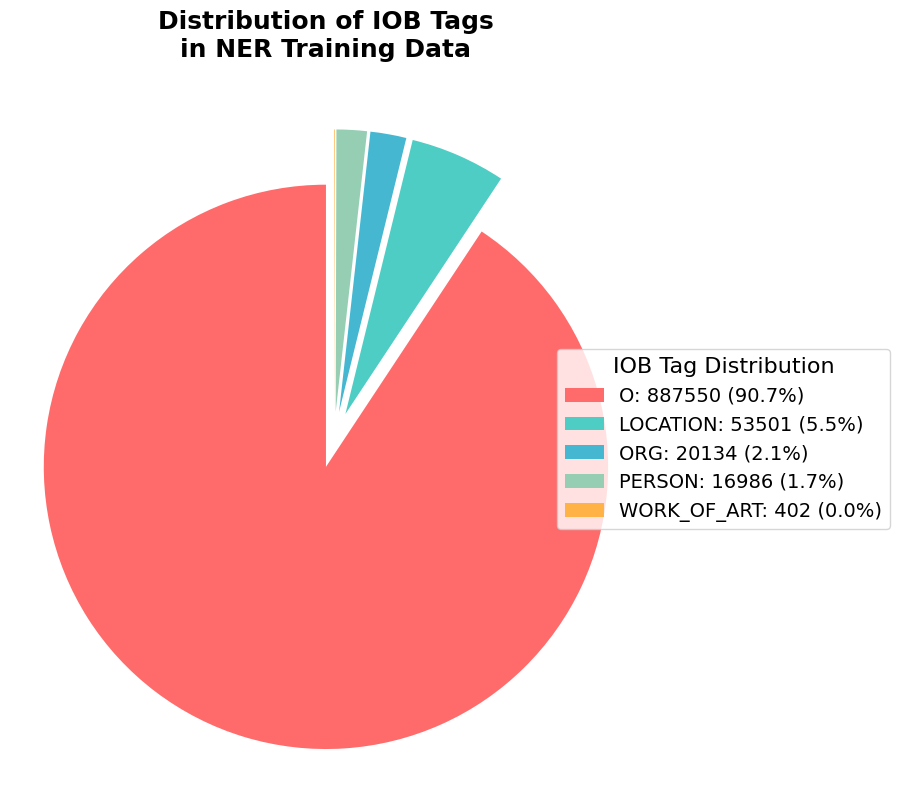

In [ ]:
# visualization training data
# Initialize counter for entity types
entity_counts = Counter()

# Process each row
for _, row in df.iterrows():
    labels = row['labels'].split()
    
    # Map labels and count entities
    for label in labels:
        if label in tag_mapping:
            mapped_label = tag_mapping[label]
            
            # Count B- tags for named entities
            if mapped_label.startswith('B-'):
                entity_type = mapped_label[2:]  # Remove 'B-' prefix
                if entity_type in ['LOCATION', 'WORK_OF_ART', 'ORG', 'PERSON']:
                    entity_counts[entity_type] += 1
            # Count O tags (non-entity tokens)
            elif mapped_label == 'O':
                entity_counts['O'] += 1

# Prepare data for pie chart
entity_types = list(entity_counts.keys())
counts = list(entity_counts.values())

# Create the pie chart
plt.figure(figsize=(9, 8))

# Custom colors for each entity type (including O)
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFB347'] 

# Adjust explode tuple based on number of categories
explode_values = tuple([0.1] * len(entity_types))  # Increased explode for better separation

# Create pie chart with custom styling
wedges, texts = plt.pie(counts,
                       labels=None,  # Remove labels from pie chart to avoid overlap
                       autopct=None,  # Remove percentages from pie chart
                       colors=colors[:len(entity_types)],  # Use only needed colors
                       startangle=90,
                       explode=explode_values,  # Dynamically adjust explode
                       textprops={'fontsize': 14, 'fontweight': 'bold'})

# Customize the appearance
plt.title('Distribution of IOB Tags\nin NER Training Data',
          fontsize=18, fontweight='bold', pad=30)

# Add count labels
for i, (entity_type, count) in enumerate(zip(entity_types, counts)):
    plt.text(0, 0, '', ha='center', va='center')

# Create a legend with counts (positioned to avoid overlap)
legend_labels = [f'{entity}: {count} ({(count/sum(counts))*100:.1f}%)' for entity, count in zip(entity_types, counts)]
plt.legend(wedges, legend_labels, title="IOB Tag Distribution", 
          loc="center left", bbox_to_anchor=(0.85, 0, 0.5, 1),
          fontsize=14, title_fontsize=16)

# Make the plot look better - no percentage text to style anymore
# plt.setp(autotexts, size=11, weight="bold", color="white")  # No longer needed

# Ensure the pie chart is circular
plt.axis('equal')

# Add some statistics
total_tokens = sum(counts)
named_entities = sum(count for entity_type, count in zip(entity_types, counts) if entity_type != 'O')
o_tokens = entity_counts.get('O', 0)

print(f"Total tokens processed: {total_tokens}")
print(f"Named entities found: {named_entities}")
print(f"Non-entity tokens (O): {o_tokens}")
print(f"Entity ratio: {(named_entities/total_tokens)*100:.1f}% entities, {(o_tokens/total_tokens)*100:.1f}% non-entities")
print()
print(f"Tag distribution:")
for entity_type, count in zip(entity_types, counts):
    percentage = (count / total_tokens) * 100
    print(f"  {entity_type}: {count} ({percentage:.1f}%)")

plt.tight_layout()
plt.show()

Total tokens processed: 188
Named entities found: 29
Non-entity tokens (O): 159
Entity ratio: 15.4% entities, 84.6% non-entities

Tag distribution:
  O: 159 (84.6%)
  LOCATION: 3 (1.6%)
  ORG: 8 (4.3%)
  WORK_OF_ART: 6 (3.2%)
  PERSON: 12 (6.4%)


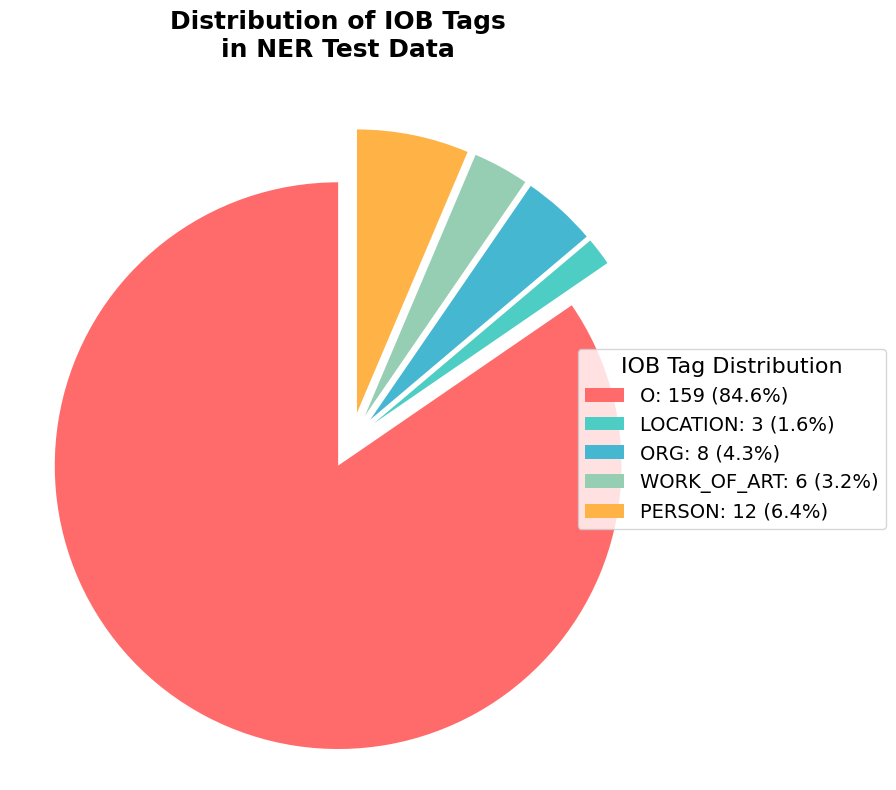

In [24]:
# Visualization test data
# Read the TSV file
df_test = pd.read_csv('NER-test.tsv', sep='\t')

# Initialize counter for entity types
entity_counts = Counter()

# Process each row
for _, row in df_test.iterrows():
    label = row['BIO_NER_tag']
    
    # Map label if it exists in mapping
    if label in tag_mapping:
        mapped_label = tag_mapping[label]
        # Count B- tags for named entities
        if mapped_label.startswith('B-'):
            entity_type = mapped_label[2:]  # Remove 'B-' prefix
            if entity_type in ['LOCATION', 'WORK_OF_ART', 'ORG', 'PERSON']:
                entity_counts[entity_type] += 1
        # Count O tags (non-entity tokens)
        elif mapped_label == 'O':
            entity_counts['O'] += 1
    else:
        # Handle direct BIO tags (B-LOCATION, B-ORG, etc.)
        if label.startswith('B-'):
            entity_type = label[2:]  # Remove 'B-' prefix
            if entity_type in ['LOCATION', 'WORK_OF_ART', 'ORG', 'PERSON']:
                entity_counts[entity_type] += 1
        # Count O tags directly
        elif label == 'O':
            entity_counts['O'] += 1

# Prepare data for pie chart
entity_types = list(entity_counts.keys())
counts = list(entity_counts.values())

# Create the pie chart
plt.figure(figsize=(9, 8))

# Custom colors for each entity type (including O)
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFB347']

# Adjust explode tuple based on number of categories
explode_values = tuple([0.1] * len(entity_types))  # Increased explode for better separation

# Create pie chart with custom styling
wedges, texts = plt.pie(counts,
                       labels=None,  # Remove labels from pie chart to avoid overlap
                       autopct=None,  # Remove percentages from pie chart
                       colors=colors[:len(entity_types)],  # Use only needed colors
                       startangle=90,
                       explode=explode_values,  # Dynamically adjust explode
                       textprops={'fontsize': 14, 'fontweight': 'bold'})

# Customize the appearance
plt.title('Distribution of IOB Tags\nin NER Test Data',
          fontsize=18, fontweight='bold', pad=30)

# Add count labels
for i, (entity_type, count) in enumerate(zip(entity_types, counts)):
    plt.text(0, 0, '', ha='center', va='center')

# Create a legend with counts (positioned to avoid overlap)
legend_labels = [f'{entity}: {count} ({(count/sum(counts))*100:.1f}%)' for entity, count in zip(entity_types, counts)]
plt.legend(wedges, legend_labels, title="IOB Tag Distribution",
           loc="center left", bbox_to_anchor=(0.85, 0, 0.5, 1),
           fontsize=14, title_fontsize=16)

# Ensure the pie chart is circular
plt.axis('equal')

# Add some statistics
total_tokens = sum(counts)
named_entities = sum(count for entity_type, count in zip(entity_types, counts) if entity_type != 'O')
o_tokens = entity_counts.get('O', 0)

print(f"Total tokens processed: {total_tokens}")
print(f"Named entities found: {named_entities}")
print(f"Non-entity tokens (O): {o_tokens}")
print(f"Entity ratio: {(named_entities/total_tokens)*100:.1f}% entities, {(o_tokens/total_tokens)*100:.1f}% non-entities")
print()
print(f"Tag distribution:")
for entity_type, count in zip(entity_types, counts):
    percentage = (count / total_tokens) * 100
    print(f"  {entity_type}: {count} ({percentage:.1f}%)")

plt.tight_layout()
plt.show()

/var/folders/cv/wcn_y6kd0hl5nqd5hcycnfm00000gn/T/ipykernel_9388/2421592271.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=agg_f1, x='base_entity', y='f1-score', palette='Set2')


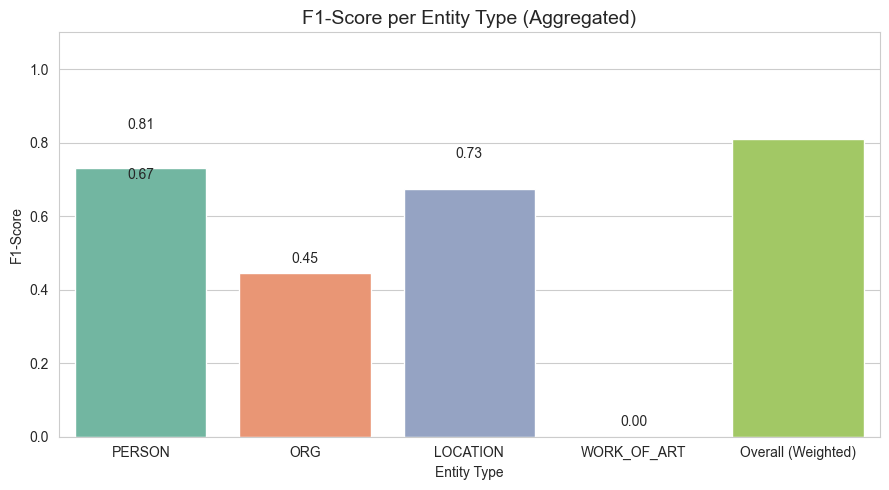

In [ ]:
# Computing F1-scores per NE type and the weighted average F1
# Generate classification report
report_dict = classification_report(flat_y_test, flat_y_pred, output_dict=True, zero_division=0)
df = pd.DataFrame(report_dict).transpose().reset_index().rename(columns={'index': 'label'})

# Clean tag names: B-ORG → ORG, etc.
df['base_entity'] = df['label'].apply(lambda x: re.sub(r'^[BI]-', '', x) if '-' in x else x)

# Only keep the 4 desired entity types
entity_types = ['ORG', 'PERSON', 'LOCATION', 'WORK_OF_ART']
filtered = df[df['base_entity'].isin(entity_types)]

# Group by base entity and get mean F1
agg_f1 = filtered.groupby('base_entity')['f1-score'].mean().reset_index()

# Add weighted average
weighted_f1 = report_dict['weighted avg']['f1-score']
agg_f1 = pd.concat([
    agg_f1,
    pd.DataFrame({'base_entity': ['Overall (Weighted)'], 'f1-score': [weighted_f1]})
])

# Sort for visual order
entity_order = ['PERSON', 'ORG', 'LOCATION', 'WORK_OF_ART', 'Overall (Weighted)']
agg_f1['base_entity'] = pd.Categorical(agg_f1['base_entity'], categories=entity_order, ordered=True)
agg_f1 = agg_f1.sort_values('base_entity')

# Plot with text labels
plt.figure(figsize=(9, 5))
sns.set_style("whitegrid")
ax = sns.barplot(data=agg_f1, x='base_entity', y='f1-score', palette='Set2')

# Annotate bars
for i, row in agg_f1.iterrows():
    ax.text(i, row['f1-score'] + 0.02, f"{row['f1-score']:.2f}", ha='center', va='bottom', fontsize=10)

# Chart formatting
plt.title('F1-Score per Entity Type (Aggregated)', fontsize=14)
plt.ylabel('F1-Score')
plt.xlabel('Entity Type')
plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()
